In [1]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn import cross_validation
from sklearn import preprocessing
import os
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib as mpl
mpl.rcParams['font.sans-serif'] = ['STHeiti']
mpl.rcParams['font.serif'] = ['STHeiti']
import seaborn as sns
sns.set_style("darkgrid",{"font.sans-serif":['STHeiti', 'STHeiti']})
# Set Default Encoding
import sys
stdout = sys.stdout
reload(sys)
sys.setdefaultencoding('utf-8')
sys.stdout = stdout

/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


# 概述
利用随机森林算法，根据基金 3 个月的数据，预测之后一个月的涨跌。
# 特征提取
## 数据读取
▍读取涨跌幅数据、基金表现和基金信息数据

In [2]:
rate = pd.read_csv('data/two_years_data.csv')
rate['date'] = pd.to_datetime(rate['date'])
rate.set_index('date',inplace=True)
#
fp = pd.read_csv('data/fund_performance.csv',dtype={'code':str})
fp.set_index('code',inplace=True)
inf = pd.read_csv('./data/mixed_funds.csv',dtype={'code':str})
inf.set_index('code',inplace=True)
fpi = pd.merge(fp,inf,left_index=True,right_index=True)
fpi.head()

,return,beta,alpha,r_squared,std,up_days,max_rate,min_rate,name,type,manager,company
code,,,,,,,,,,,,
000001,-0.046535,1.197893,-0.070828,92.254118,1.001862,226,2.89,-6.27,华夏成长,混合型,董阳阳,华夏基金
000011,0.079641,1.532346,0.056941,86.012987,1.327264,249,5.12,-8.16,华夏大盘精选,混合型,陈伟彦,华夏基金
000017,-0.056323,1.497941,-0.079187,86.969193,1.290311,228,4.44,-7.73,财通可持续混合,混合型,金梓才,财通基金
000020,0.122270,1.657785,0.100167,91.334419,1.393457,244,5.27,-8.17,景顺长城品质投资混合,混合型,詹成,景顺长城基金
000021,-0.032180,1.686314,-0.054146,96.567434,1.378497,226,4.76,-8.14,华夏优势增长混合,混合型,郑晓辉,华夏基金


## 数据预处理
经理和公司也是基金的特征之一，体现经理和公司的优劣主要是基金的业绩。这里考虑用经理和公司的平均收益代表经理和公司。

In [3]:
manger_dict = fpi.groupby('manager')['return'].mean().to_dict()
fpi['manager'] = fpi['manager'].replace(manger_dict)
company_dict = fpi.groupby('company')['return'].mean().to_dict()
fpi['company'] = fpi['company'].replace(company_dict)

▍删掉基金名字和类型

In [4]:
fpi.drop(['name','type'],axis=1,inplace=True)

▍将涨跌幅数据转换为涨跌等级

In [5]:
rate_range = [rate.unstack().quantile(x) for x in np.arange(11)/10.]
rate_range[0] = rate_range[0] - 0.1
rate_range = np.sort(list(set(rate_range)))
n = len(rate_range)
rate_level = rate.apply(lambda x: pd.cut(x,rate_range,labels=np.arange(n-1)))
#

In [9]:
rate_range

array([ -6.76700000e+01,  -8.00000000e-01,  -3.50000000e-01,
        -1.10000000e-01,   0.00000000e+00,   9.00000000e-02,
         2.10000000e-01,   4.60000000e-01,   9.20000000e-01,
         2.08610000e+02])

## 特征集和标签集
提取每半年的数据作为特征集，根据半年后第一个月的表现给定标签。值得说明的是，并不是第七个月的涨跌幅为正就判定基金涨了，而是与预期涨幅(month_rate) 比较，超过预测涨幅则判定基金涨了，预期涨幅为基金平均表现的月化收益。每次往后滑动一个月。

In [10]:
time_range = pd.date_range('2016-01',periods=22,freq='M').strftime('%Y-%m')
#month_rate = ((rate/100+1).cumprod().ix[-1].quantile(0.75)-1)*250/len(rate)/12
month_rate = ((rate/100+1).cumprod().ix[-1].mean()-1)*250/len(rate)/12

In [11]:
fea = pd.DataFrame()
for i in range(len(time_range)-7):
    s_time = time_range[i]
    e_time = time_range[i+5]
    # 
    level_nums = []
    for level in np.arange(n-1):
        level_nums.append((rate_level[s_time:e_time]==level).sum())
    col_labels = ['L'+str(x) for x in np.arange(n-1)]
    df_level = pd.DataFrame(level_nums).T
    df_level.columns = col_labels
    # label
    label = (rate[time_range[i+3]]/100+1).cumprod().ix[-1]>month_rate+1
    label.name = 'label'
    #
    df_merge = pd.concat([df_level,fpi,label],axis=1).reset_index()
    df_merge.rename(index=str, columns={},inplace=True)
    #
    fea = pd.concat([fea,df_merge])
#
fea.reset_index()
fea.drop('index',inplace=True)

In [12]:
month_rate*12

0.024924347283937318

▍将所有特征离散化为 10 个等级

In [14]:
X = fea.drop(['code','label'],axis=1)
def dis_ten(fea):
    """fea: Series"""
    fea_range = [fea.quantile(x) for x in np.arange(11)/10.]
    # the bins not include the leftmost edge
    fea_range[0] = fea_range[0] - 0.1
    fea_range = set(fea_range)
    fea_range = np.sort(list(fea_range))
    return pd.cut(fea,fea_range,labels=np.arange(len(fea_range)-1))
X_scaler = X.apply(lambda x: dis_ten(x))
#
y = fea['label']

In [15]:
no_trees = range(1,30)
# 10 折
k_fold=10
#
df_random_forest = pd.DataFrame()
# 交叉验证并评分
for i in no_trees:    
    forest = RandomForestClassifier(n_estimators=i)
    scores = cross_validation.cross_val_score(forest, X_scaler, y,scoring='f1', cv=k_fold)
    df_random_forest[str(i)]=scores

,1,2,3,4,5,6,7,8,9,10,...,20,21,22,23,24,25,26,27,28,29
0,0.586077,0.465250,0.588690,0.520256,0.614943,0.564972,0.608944,0.560164,0.603828,0.561313,...,0.584784,0.600487,0.574724,0.596680,0.586310,0.592773,0.584615,0.594595,0.582920,0.606149
1,0.634705,0.584859,0.665270,0.625398,0.688039,0.656126,0.701541,0.682779,0.703349,0.692500,...,0.699548,0.709933,0.703234,0.716049,0.707655,0.719936,0.710174,0.717160,0.706592,0.719181
2,0.638486,0.577386,0.655513,0.624427,0.664384,0.655738,0.680489,0.669276,0.672331,0.676270,...,0.679912,0.685900,0.681967,0.701616,0.678311,0.690000,0.682766,0.686941,0.680525,0.693381
3,0.610492,0.556440,0.632411,0.592174,0.641670,0.608768,0.647306,0.638076,0.659290,0.633013,...,0.648297,0.663411,0.636119,0.652710,0.650648,0.655224,0.643652,0.658482,0.646457,0.648426
4,0.565814,0.407778,0.568729,0.527415,0.590056,0.530381,0.597183,0.548306,0.617606,0.568618,...,0.572973,0.602546,0.595930,0.607177,0.585987,0.601618,0.595785,0.605152,0.594749,0.604520


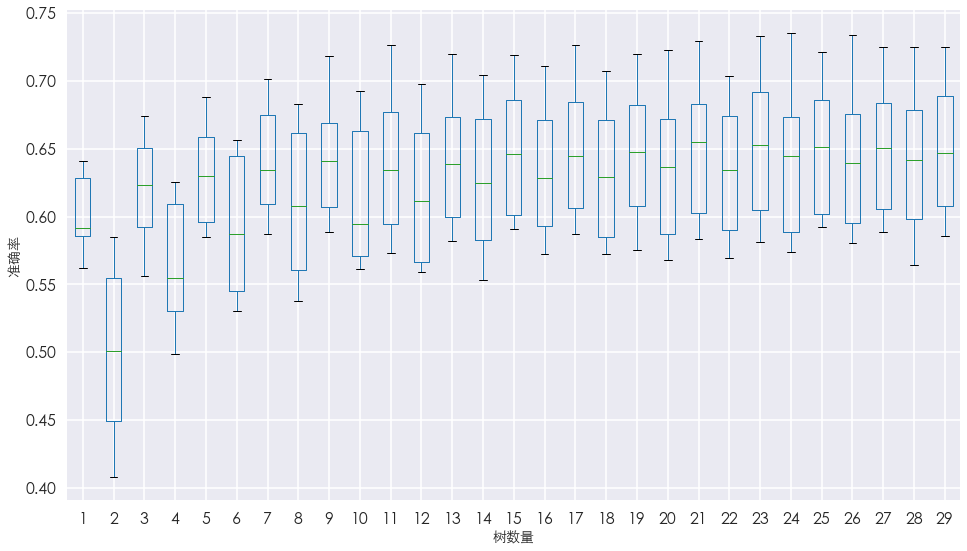

In [20]:
plt.figure(figsize=(16,9))
df_random_forest.boxplot()
plt.xlabel( u"树数量", fontsize=14)
plt.ylabel(u"准确率", fontsize=14)
sns.set_context('poster')

In [21]:
forest = RandomForestClassifier(n_estimators=25)
clf = forest.fit(X_scaler,y)

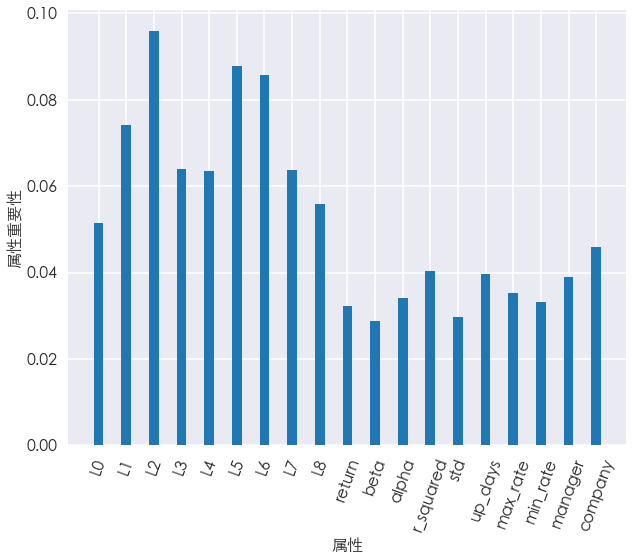

In [22]:

index = np.arange(len(X_scaler.columns))

plt.figure(figsize=(10,8))
plt.bar(index, clf.feature_importances_, 0.35,label='')
plt.xlabel('属性', fontsize =16)
plt.ylabel('属性重要性', fontsize =16)
plt.xticks(index, X_scaler.columns,rotation = 70)